# Repulsive interaction

We will in this notebook use importance sampling to compute the ground state energies for the repulsive system with an elliptical harmonic oscillator trap.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from vmc.interface import *
from vmc import run_all

from IPython.core.display import display

In [2]:
sns.set(color_codes=True)

In [87]:
mass = 1.0
omega = 1.0

beta = _lambda = np.sqrt(8)
radius = 0.0043

num_particles_list = [2, 10, 50, 100]
num_dimensions = 3

step_length = 0.1

num_samples = int(2**18)
num_thermalization_steps = int(0.1*num_samples)

alpha_min = 0.5*omega - 0.3
alpha_max = 0.5*omega + 0.3
num_alphas = 7

parameter_names = ["alpha"]

alphas = np.linspace(alpha_min, alpha_max, num_alphas).reshape(num_alphas, 1)
bootstrap_samples = 0

In [88]:
def output_table(df, filename):
    columns = list(df)
    columns.remove("variance")
    columns.remove("std")
    columns.remove("block_var")

    df[columns].to_csv(
        filename,
        index=False,
        sep="&",
        header=[
            r"$\alpha$", r"$\langle E_L\rangle$",
            r"$A$", r"$t_C$", r"$\sigma_b$"],
        float_format="%.5f",
        line_terminator="\\\\ \n",
        quotechar=" "
    )

100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std
0,0.2,7.004697,4.157492e-05,0.006448,0.990482,0.337682,8.998011e-04,0.029997
1,0.3,5.463072,1.063640e-05,0.003261,0.982330,0.328087,1.517425e-04,0.012318
2,0.4,4.951239,1.928916e-06,0.001389,0.973373,0.325780,2.255292e-05,0.004749
3,0.5,4.834204,1.177704e-10,0.000011,0.962318,0.330230,8.850908e-10,0.000030
4,0.6,4.915391,1.297300e-06,0.001139,0.950451,0.345329,1.011716e-05,0.003181
5,0.7,5.116937,4.438498e-06,0.002107,0.938576,0.330285,3.048244e-05,0.005521
6,0.8,5.366157,9.209614e-06,0.003035,0.925430,0.319414,6.066480e-05,0.007789


100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std
0,0.2,35.264198,2.013371e-04,0.014189,0.989925,1.598318,1.828627e-02,0.135227
1,0.3,27.631706,5.776894e-05,0.007601,0.981907,1.559983,4.154695e-03,0.064457
2,0.4,24.988022,9.685594e-06,0.003112,0.971672,1.567920,5.081681e-04,0.022543
3,0.5,24.399254,1.011588e-08,0.000101,0.961559,1.528917,5.424283e-07,0.000736
4,0.6,24.840140,6.596865e-06,0.002568,0.949703,1.531190,2.658515e-04,0.016305
5,0.7,25.857014,2.336136e-05,0.004833,0.936699,1.527538,8.632096e-04,0.029380
6,0.8,27.217316,4.627208e-05,0.006802,0.923359,1.481642,1.389867e-03,0.037281


100%|██████████| 7/7 [00:31<00:00,  4.46s/it]


,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std
0,0.2,71.421619,4.180289e-04,0.020446,0.989231,4.561581,0.070888,0.266247
1,0.3,55.582915,1.066155e-04,0.010325,0.980682,4.462857,0.014325,0.119688
2,0.4,50.478904,1.854632e-05,0.004307,0.971512,4.477624,0.001817,0.042622
3,0.5,49.346263,7.165543e-08,0.000268,0.959988,4.414957,0.000010,0.003210
4,0.6,50.229234,1.440923e-05,0.003796,0.949604,4.500615,0.001190,0.034504
5,0.7,52.322495,4.785347e-05,0.006918,0.935631,4.429929,0.003212,0.056673
6,0.8,55.254367,9.491239e-05,0.009742,0.923157,4.297415,0.006560,0.080991


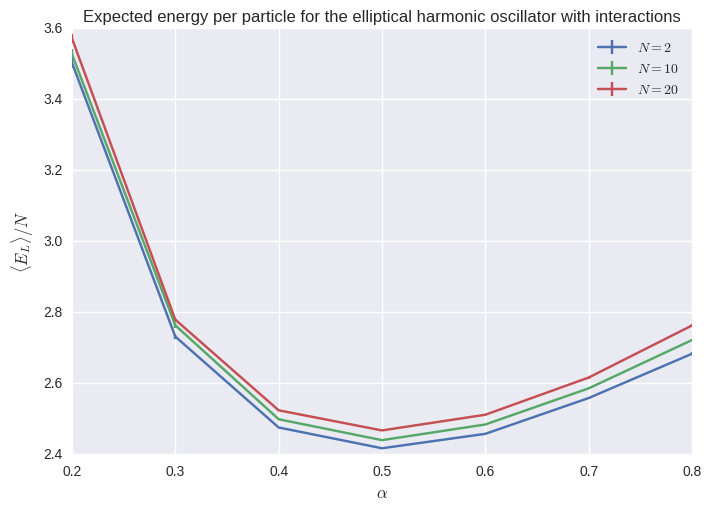

In [91]:
for num_particles in [2, 10, 20]:
    kwargs = {
        "num_samples": num_samples, "num_thermalization_steps": num_thermalization_steps,
        "step_length": step_length
    }

    wavefunction = PyInteractingEllipticalGaussian(
        num_particles, num_dimensions, mass, omega, beta, radius, spread=np.sqrt(step_length)
    )

    sampler_int = PySampler(
        wavefunction, PyEllipticalHarmonicOscillator(_lambda), PyImportanceMetropolis()
    )

    df_int = run_all(
        sampler_int, alphas, parameter_names, bootstrap_samples, **kwargs
    )

    display(df_int)

    output_table(df_int, "../data/tables/3D{0}N_interaction.dat".format(num_particles))

    plt.errorbar(
        df_int["alpha"], df_int["energy"]/num_particles,
        yerr=df_int["block_std"]/num_particles, label=r"$N = %d$" % num_particles
    )

plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel(r"$\langle E_L\rangle/N$", fontsize=12)
plt.title(r"Expected energy per particle for the elliptical harmonic oscillator with interactions")
plt.legend(loc="best")
plt.savefig("../data/figures/problem_e.pdf")
plt.show()